In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.misc as misc
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
def scale(img):
    return (img / 255.)

In [3]:
## 데이터 importing

pwd = os.getcwd()
path = os.path.join(pwd,"extracted_images")
l1=os.listdir(path = path)

X_full=[]
Y_full=[]
label_list=[]

i=0

for dir in l1:
    if(dir[0]=="."): continue # skip .DS_
    path1 = os.path.join(path,dir)
    allfiles = os.listdir(path1)
    print(dir)
    label_list.append(dir[0])
    j=0
    
    for file in allfiles:
        if(j>500): break
        if(file[0:3]==".DS"): continue
        t1 = os.path.join(path1,file)
        a1 = misc.imread(t1).flatten()
        X_full.append(scale(a1))
        Y_full.append(i)
        j+=1
        
    i+=1

k
o


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


]
9
neq
z
pi
i
phi
)
C
G
3
5
f
ldots
sigma
!
j
7
gamma
exists
1
pm
leq
mu
S
Delta
R
q
M
y
sum
times
}
p
rightarrow
lim
4
l
{
+
int
alpha
lt
T
=
b
6
gt
A
N
H
-
tan
div
cos
theta
2
forall
infty
w
X
e
8
(
geq
sqrt
v
sin
,
[
beta
in
log
u
lambda
d
forward_slash
prime
ascii_124
0


In [4]:
XX=np.array(X_full)
YY=np.array(Y_full)

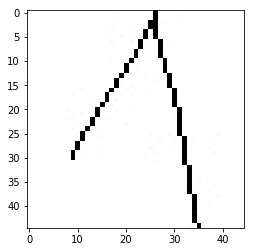

In [6]:
## 데이터 그려보기
plt.imshow(XX[9991].reshape(45,45),cmap=plt.cm.gray)

In [7]:
## Split images
X_train,X_test,y_train,y_test = train_test_split(XX,YY,random_state=77,test_size=.15)

In [8]:
sizeInput = X_train.shape[1]  # input vector size 45*45 이미지
OutputVector = 82 # 82개 label 

# one hot encoding
sam = np.eye(OutputVector)

train_label=sam[y_train.flatten()-1]
test_label =sam[y_test.flatten()-1]

In [9]:
train_label.shape

(31477, 82)

In [10]:
### CNN 모델링

### 중간 학습 과정 변화

class Model:
    
    def __init__(self,sess,name):
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self):
        
        with tf.variable_scope(self.name):
            
            self.learning_rate=0.7 # 일단 0.5는 잘 된다
            self.training = tf.placeholder(tf.bool)
            
            ### placeholder
            self.X = tf.placeholder(tf.float32,[None,sizeInput])
            self.Y = tf.placeholder(tf.float32,[None,OutputVector])
            # 이미지 형식으로 형태 변환
            self.X_img = tf.reshape(self.X,[-1,45,45,1]) 
            
            ## conv layer 1 -> 5*5*32 filter
            ## relu activation 함수 사용하고, kernel size는 5*5 , ouput filter 개수가 32개, stride는 1칸씩
            ## max pooling 2*2 -> 23*23로 줄여짐
            ## dropout with ratio 0.7
            
            with tf.variable_scope('layer1'):
                conv1 = tf.layers.conv2d(self.X_img,filters=32,kernel_size=5,strides=1,
                                         padding="SAME",activation=tf.nn.relu) 
        
                pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding="SAME")
            
                dropout1 = tf.layers.dropout(pool1,rate=0.7,training=self.training)
                
            ## conv layer 2 -> 3*3*64 filters
            ## relu activation 함수 사용하고, kernel size는 3*3 , ouput filter 개수가 64개, stride는 1칸씩
            ## max pooling 2*2 -> 12*12로 줄여짐 (반올림)
            ## dropout with ratio 0.7
                
            with tf.variable_scope('layer2'):
                conv2 = tf.layers.conv2d(dropout1,filters=64,kernel_size=3,strides=1,
                                        padding="SAME",activation=tf.nn.relu)

                pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding="SAME")
                dropout2 = tf.layers.dropout(pool2,rate=0.7,training=self.training)
                
            ## conv layer 3 -> 3*3*128 filters
            ## relu activation 함수 사용하고, kernel size는 3*3 , ouput filter 개수가 128개, stride는 1칸씩
            ## max pooling 2*2 -> 6*6로 줄여짐 
            ## dropout with ratio 0.7

            with tf.variable_scope('layer3'):
                conv3 = tf.layers.conv2d(dropout2,filters=128,kernel_size=3,strides=1,
                                        padding="SAME",activation=tf.nn.relu)
                pool3 = tf.layers.max_pooling2d(conv3,pool_size=2,strides=2,padding="SAME")
                dropout3 = tf.layers.dropout(pool3,rate=0.7,training=self.training)
                
            s1 = int(dropout3.shape[1])
            
            ###### fully connected layer 마지막으로 만들어줌
            ## 6*6*128 -> output 1024개 
            ## relu activation 사용함
            
            with tf.variable_scope('layer4'):
                flat = tf.reshape(dropout3,[-1,s1*s1*128])
                f4 = tf.layers.dense(flat,units=1024,activation=tf.nn.relu)
                dropout4 = tf.layers.dropout(f4,rate=0.5,training=self.training)
                
            with tf.variable_scope('output'):
                self.logits = tf.layers.dense(dropout4,units=OutputVector)
                
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,labels=self.Y))
        self.optimizer = tf.train.AdadeltaOptimizer(self.learning_rate).minimize(self.cost)
        
        correct_prediction=tf.equal(tf.argmax(self.logits,1),tf.argmax(self.Y,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        
        # 예측값 출력하는 함수
    def predict(self,X_test,training=False):
        return self.sess.run(self.logits,
                            feed_dict={self.X:X_test,self.training:training})
        # 정확도 측정
    def get_accuracy(self,X_test,Y_test,training=False):
        return self.sess.run(self.accuracy,
                            feed_dict={self.X:X_test,self.Y:Y_test,self.training:training})
        # 학습 함수
    def train(self,x_data,y_data,training=True):
        return self.sess.run([self.cost,self.optimizer],
                            feed_dict={self.X:x_data,self.Y:y_data,self.training:training})

In [11]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess = tf.Session(config=config)

models = Model(sess,name='m1')

sess.run(tf.global_variables_initializer())


### hyper parameter

## 배치사이즈 200, 50회 학습

batch_size = 200
train_epoch = 50

num_batch = int(len(X_train)/batch_size)

training_acc_cnn=[]
test_acc_cnn=[]

print("Start Training")

for epoch in range(train_epoch):
    
    p1 = np.random.permutation(len(X_train))
    x_data = X_train[p1]
    y_data = train_label[p1]
    
    p2 = np.random.permutation(len(X_test))
    x_test = X_test[p2]
    y_test = test_label[p2]
    
    avg_cost=0.
    
    for i in range(0,num_batch):
        batch_xs,batch_ys = x_data[i*batch_size:((i+1)*batch_size)],y_data[i*batch_size:((i+1)*batch_size)]
        
        c,_ = models.train(batch_xs,batch_ys)
        avg_cost += c/(num_batch)
        
    print('Epoch:', '%04d' % (epoch+1),'cost = ',avg_cost)
    
    training_acc_cnn.append(models.get_accuracy(x_data,y_data))
    test_acc_cnn.append(models.get_accuracy(x_test,y_test))
    
print('Learning Finished')
    
sess.close()

Start Training
Epoch: 0001 cost =  4.4563434777
Epoch: 0002 cost =  4.30307217768
Epoch: 0003 cost =  2.80189485763
Epoch: 0004 cost =  2.00118865101
Epoch: 0005 cost =  1.71632247062
Epoch: 0006 cost =  1.51648404872
Epoch: 0007 cost =  1.35774272187
Epoch: 0008 cost =  1.24080063317
Epoch: 0009 cost =  1.13798805673
Epoch: 0010 cost =  1.06032118942
Epoch: 0011 cost =  0.989493504072
Epoch: 0012 cost =  0.939421146918
Epoch: 0013 cost =  0.892999843427
Epoch: 0014 cost =  0.845671760428
Epoch: 0015 cost =  0.802843244972
Epoch: 0016 cost =  0.775041262056
Epoch: 0017 cost =  0.742760783168
Epoch: 0018 cost =  0.708530929818
Epoch: 0019 cost =  0.689141770457
Epoch: 0020 cost =  0.660717338134
Epoch: 0021 cost =  0.639452415857
Epoch: 0022 cost =  0.625130452168
Epoch: 0023 cost =  0.599618798608
Epoch: 0024 cost =  0.595991727273
Epoch: 0025 cost =  0.576683306011
Epoch: 0026 cost =  0.560828892479
Epoch: 0027 cost =  0.549353835309
Epoch: 0028 cost =  0.541733312569
Epoch: 0029 cost

In [14]:
### 회귀모형 적합

X = tf.placeholder(tf.float32,[None,sizeInput])
Y = tf.placeholder(tf.float32,[None,OutputVector])

W = tf.Variable(tf.random_normal([sizeInput,OutputVector],mean=0,stddev=0.1))
b = tf.Variable(tf.zeros([OutputVector]))

y_hat = tf.matmul(X,W) + b

learning_rate = 0.05

## 비용함수 정의 및 Adam optimizer로 최소화

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat,labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y_hat,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))


batch_size = 200
train_epoch = 50

num_batch = int(len(X_train)/batch_size)

training_acc_reg=[]
test_acc_reg=[]

print("Start Training")

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())

for epoch in range(train_epoch):
    
    p1 = np.random.permutation(len(X_train))
    x_data = X_train[p1]
    y_data = train_label[p1]
    
    p2 = np.random.permutation(len(X_test))
    x_test = X_test[p2]
    y_test = test_label[p2]
    
    avg_cost=0.
    
    for i in range(0,num_batch):
        batch_xs,batch_ys = x_data[i*batch_size:((i+1)*batch_size)],y_data[i*batch_size:((i+1)*batch_size)]
        
        c,_ = sess.run([cost,optimizer],feed_dict={X:batch_xs,Y:batch_ys})
        avg_cost += c/(num_batch)
        
    print('Epoch:', '%04d' % (epoch+1),'cost = ',avg_cost)
    
    training_acc_reg.append(sess.run(accuracy,feed_dict={X:x_data,Y:y_data}))
    test_acc_reg.append(sess.run(accuracy,feed_dict={X:x_test,Y:y_test}))
    
print('Learning Finished')

Start Training
Epoch: 0001 cost =  633.72449539
Epoch: 0002 cost =  180.854275309
Epoch: 0003 cost =  99.8821235948
Epoch: 0004 cost =  39.087531679
Epoch: 0005 cost =  32.2413267877
Epoch: 0006 cost =  51.8353551998
Epoch: 0007 cost =  64.4091431685
Epoch: 0008 cost =  41.1158266553
Epoch: 0009 cost =  12.4224438758
Epoch: 0010 cost =  20.3165844929
Epoch: 0011 cost =  30.7426229526
Epoch: 0012 cost =  41.066606388
Epoch: 0013 cost =  22.7660311255
Epoch: 0014 cost =  16.9986742864
Epoch: 0015 cost =  54.8789619276
Epoch: 0016 cost =  50.3550457924
Epoch: 0017 cost =  29.5931101514
Epoch: 0018 cost =  12.2879201971
Epoch: 0019 cost =  7.61515110921
Epoch: 0020 cost =  10.2298718228
Epoch: 0021 cost =  20.8479712298
Epoch: 0022 cost =  50.2595236954
Epoch: 0023 cost =  30.4075428544
Epoch: 0024 cost =  9.63181642362
Epoch: 0025 cost =  12.3772252745
Epoch: 0026 cost =  14.9965745112
Epoch: 0027 cost =  28.5517232008
Epoch: 0028 cost =  28.5085706832
Epoch: 0029 cost =  9.18313154445
Ep

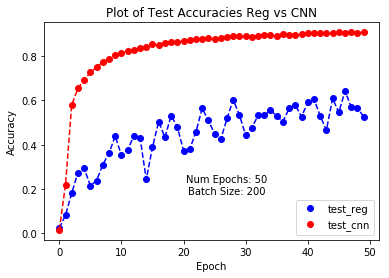

In [18]:
plt.plot(test_acc_reg,'bo',label="test_reg")
plt.plot(test_acc_reg,'b--')
plt.plot(test_acc_cnn,'ro',label="test_cnn")
plt.plot(test_acc_cnn,'r--')
plt.ylabel('Accuracy')  # Accuracy label
plt.xlabel('Epoch')
plt.title('Plot of Test Accuracies Reg vs CNN')
plt.legend()
ax = plt.gca()
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
midXLoc = (xmax - xmin)/2
topYLoc = ymax - (ymax-ymin)*0.7
plt.text(midXLoc, topYLoc, 'Num Epochs: ' + str(train_epoch) + '\nBatch Size: ' + str(batch_size), ha='center', va='top')

In [ ]:
plt.savefig('Code2_test_error', dpi=300)

In [19]:
np.max(test_acc_cnn)

0.90765077